***
# Assignment 2 Social Graphs 2023

**Link to assignment description:** https://github.com/SocialComplexityLab/socialgraphs2023/blob/main/assignments/Assignment2.ipynb

This assignment applies the following formatting:

* Original assignment text is marked with a bullet point or unformatted text.

> **✅ Solution**: A solution is marked with a checkmark emoji.

> **📊 Graph**: A caption for a graph has a graph emoji.

> **💬 Comment**: An additional comment uses a speech bubble emoji.
***

## Table of Contents
* [0. Building the network](#network)
* [1. Network visualization and basic stats](#network_stats)
    * [1.a Stats](#stats)
    * [1.b Visualization](#viz)
* [2. Word-clouds](#wordclouds)
* [3. Communities](#communities)
* [4. Sentiment of communities](#sentiment)
* [5. References](#references)

## Requirements <a class="anchor" id="requirements"></a>

In [26]:
from collections import Counter
from nltk import FreqDist
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import powerlaw
import math
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import os
import pandas as pd
import pickle as pkl
import re
import string
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 0. Building the network <a class="anchor" id="network"></a>
To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

- Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

**Solution:**

First, we iterate over all the rapper text files and add them as nodes in the network, including attributes such as Coast and Content Length. 

Then, we iterate through the same set of files once again, performing the following steps:

1. Search for Wikipedia internal links that follow a specific format (identified using a regular expression, explained in the next section).

2. Sometimes these links include more than one word, separated by '|', but we are only interested in the first word.

3. Check if the resulting word or phrase is present in the collection of rapper names provided at the beginning of Week 4.

4. If it is, connect the rapper associated with the current file we are iterating over (edge origin) to the rapper mentioned in the Wikipedia internal link (edge destination). The direction of this edge is important.


- Show the regular expressions you have built and explain in details how they work.

**✅ Solution**

We are using the following regular expression: `\[\[(.*?)\]\]`, which essentially matches everything between double square brackets. In particular:

- The square brackets `\[\]` are escaped with a backslash (`\`) to ensure they are matched literally.
- The parenthesis `( )` form a group (although as it's only one group in the whole expression that we don't need to match as repeating, the parenthesis can be removed).
- `.*?`: This is a part of the pattern enclosed in parentheses and it's the interesting part. It uses the following elements:
  - `.`: This period (dot) is a metacharacter in regular expressions that matches any character except for a newline character.
  - `*`: This asterisk is another metacharacter and it means "zero or more occurrences of the preceding element." So, `.*` means zero or more occurrences of any character.
  - `?`: The question mark is another metacharacter, and when used after `*`, it makes the `*` operator non-greedy, meaning it matches as few characters as possible. Without the `?`, `.*` would be greedy and match as many characters as possible, so from the first link's `[[`, to the last link's `]]`.


In [6]:
west_df = pd.read_csv('/Users/dianapodoroghin/Desktop/SocialGraphs/socialgraphs2023/files/WestCoastRappers.csv')
east_df = pd.read_csv('/Users/dianapodoroghin/Desktop/SocialGraphs/socialgraphs2023/files/EastCoastRappers.csv')

# Add a 'Location' column to each DataFrame
west_df['Location'] = 'West'
east_df['Location'] = 'East'

# Concatenate the two DataFrames into one
combined_df = pd.concat([west_df, east_df])

# Reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)

# Now, combined_df contains all the rappers from both East and West with a 'Location' column.
print(combined_df.head())

   Unnamed: 0 WikipediaPageName Location
0           0         03 Greedo     West
1           1          24kGoldn     West
2           2          40 Glocc     West
3           3   A-Plus (rapper)     West
4           4         DJ A-Tron     West


In [7]:
import requests
pattern1 = r"\[\[(.*?)\]\]"
pattern2 = r"\{\{(?:Term|Plural)\|(?:.*?)\|(.*?)\|(?:.*?)\}\}"
links = []


# Update the get_links function to extract content correctly
def get_links(content, source):
    # Extract the content text from the JSON response
    pages = content['query']['pages']
    # Since there can be multiple pages, you might need to loop through them

    for page_id, page_info in pages.items():
        content_text = page_info['revisions'][0]['*']
        # print(content_text)

        pattern1_matches = re.findall(pattern1, content_text)
        pattern2_matches = re.findall(pattern2, content_text)


        # Filter and refine the matches as you did before
        pattern1_matches = list(filter(lambda x: x in list(combined_df.WikipediaPageName) and x != source, pattern1_matches))
        pattern2_matches = list(filter(lambda x: x in list(combined_df.WikipediaPageName) and x != source, pattern2_matches))
        pattern1_matches.extend(pattern2_matches)
        return pattern1_matches

# The rest of your code remains unchanged


for rapper in combined_df.WikipediaPageName:
    params = {
    "action":"query",
    "prop": "revisions",
    "rvprop":"content",
    "format": "json",
    "titles": rapper,
    "rvlimit": 1 
}   



    # Print the URL before making the request
    url = "https://en.wikipedia.org/w/api.php?" + "&".join(f"{key}={value}" for key, value in params.items())
    print(f"Querying URL for {rapper}: {url}")

    wikitext = requests.get(url)
    wikijson = wikitext.json()
    # Extract and accumulate the links for the current rapper
    link = get_links(wikijson, rapper)
    print(f"link: {link}")
    links.append(link)



Querying URL for 03 Greedo: https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=03 Greedo&rvlimit=1
link: ['Mike Free']
Querying URL for 24kGoldn: https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=24kGoldn&rvlimit=1
link: ['Ty Dolla Sign', 'Lil Tecca', 'Skizzy Mars', 'Wiz Khalifa', 'Wiz Khalifa']
Querying URL for 40 Glocc: https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=40 Glocc&rvlimit=1
link: ['Ras Kass', 'Kurupt', 'Dr. Dre', 'Dr. Dre', 'Ras Kass']
Querying URL for A-Plus (rapper): https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=A-Plus (rapper)&rvlimit=1
link: []
Querying URL for DJ A-Tron: https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=DJ A-Tron&rvlimit=1
link: ['Nipsey Hussle', 'Nipsey Hussle', 'TeeFlii']
Querying URL for Ab-Soul: https://en.wiki

In [8]:
combined_df.insert(2, 'Links', links) 

## 1. Network visualization and basic stats <a class="anchor" id="network_stats"></a>
Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

In [36]:
G = nx.DiGraph()

# iterate through all the rows in pandas df and add nodes
for index, row in combined_df.iterrows():
    name = row['WikipediaPageName']
    Location = row['Location']
    # add node and store properties
    G.add_node(name)
    G.add_node(name, Location=Location)
    links = row['Links']
    for link in links:
        if link != name: # do not include links that point to the same character
            G.add_edge(name, link)

In [31]:
print(f"Number of isolated nodes in graph: {len(list(nx.isolates(G)))}")


Number of isolated nodes in graph: 77


In [12]:
G.remove_nodes_from(list(nx.isolates(G))) # remove isolated nodes in graph
print(f"Number of isolated nodes in graph after removal: {len(list(nx.isolates(G)))}")

Number of isolated nodes in graph after removal: 0


In [13]:
gcc = max(nx.weakly_connected_components(G), key=len) # find the maximum connected component in G
G = G.subgraph(gcc) # the gcc we will operate with
G_undirected = G.to_undirected() # convert gcc to undirected graph

## Exercise 1a: Stats <a class="anchor" id="stats"></a>
- What is the number of nodes in the network?

**✅ Solution**

In [14]:
print(f"The number of nodes in network is {len(G.nodes())}")

The number of nodes in network is 719


- What is the number of links?

**✅ Solution**

In [16]:
print(f"The number of links in network is {len(G.edges())}")

The number of links in network is 5024


- Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

**✅ Solution**

In [17]:
# create a list of tuples containing the node (n) and its degree (d) - for the in and out degrees
in_degrees = [(n,d) for n,d in G.in_degree()] 
out_degrees = [(n,d) for n,d in G.out_degree()]

# sort the in- and out-degrees from high to low by degree (second element in the tuple - at index 1)
in_degrees.sort(reverse=True, key=lambda x: x[1])
out_degrees.sort(reverse=True, key=lambda x: x[1])

print(f"The top connected rapper in-degrees is: {in_degrees[0][0]}, which has a degree of {in_degrees[0][1]}")
print(f"The top connected rapper out-degrees is: {out_degrees[0][0]}, which has a degree of {out_degrees[0][1]}")

The top connected rapper in-degrees is: Snoop Dogg, which has a degree of 123
The top connected rapper out-degrees is: Drag-On, which has a degree of 43


💬 Comment:

Snoop Dogg having the highest in-degrees in the rap industry (123) is a reflection of his extensive and enduring influence. It's not surprising, considering his long, successful career and collaborations with a wide range of artists. 


The fact that Drag-On has the highest out-degrees among rappers (a degree of 43) is interesting. It could be expected if he actively collaborated with many artists during his career.

- Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 

**✅ Solution**

In [18]:

# Create a graph for East Coast
G_east = nx.DiGraph()

# Add nodes and edges based on the 'Links' column and 'Location' column
for index, row in combined_df.iterrows():
    rapper = row['WikipediaPageName']
    links = row['Links']
    location = row['Location']
    
    if location == 'East':
        for link in links:
            G_east.add_edge(rapper, link)

# Calculate in-degrees and out-degrees for East Coast
east_in_degrees = G_east.in_degree()
east_out_degrees = G_east.out_degree()

# Sort in-degrees and out-degrees in descending order for East Coast
east_in_degrees = sorted(east_in_degrees, key=lambda x: x[1], reverse=True)
east_out_degrees = sorted(east_out_degrees, key=lambda x: x[1], reverse=True)

# Print the top 5 connected rappers for in-degrees and out-degrees for East Coast
print("East Coast Analysis:")
print("Top 5 connected East Coast rappers for in-degrees:")
for n, d in east_in_degrees[:5]:
    print(f"\t{n}, which has a degree of {d}")

print("\nTop 5 connected East Coast rappers for out-degrees:")
for n, d in east_out_degrees[:5]:
    print(f"\t{n}, which has a degree of {d}")


East Coast Analysis:
Top 5 connected East Coast rappers for in-degrees:
	Jay-Z, which has a degree of 92
	Nas, which has a degree of 76
	Busta Rhymes, which has a degree of 70
	50 Cent, which has a degree of 58
	Jadakiss, which has a degree of 48

Top 5 connected East Coast rappers for out-degrees:
	Drag-On, which has a degree of 43
	Black Thought, which has a degree of 34
	French Montana, which has a degree of 31
	Jahlil Beats, which has a degree of 31
	Uncle Murda, which has a degree of 30


**✅ Solution**

- Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?

In [19]:
# Create a graph for West Coast
G_west = nx.DiGraph()

# Add nodes and edges based on the 'Links' column and 'Location' column
for index, row in combined_df.iterrows():
    rapper = row['WikipediaPageName']
    links = row['Links']
    location = row['Location']
    
    if location == 'West':
        for link in links:
            G_west.add_edge(rapper, link)

# Calculate in-degrees and out-degrees for West Coast
west_in_degrees = G_west.in_degree()
west_out_degrees = G_west.out_degree()

# Sort in-degrees and out-degrees in descending order for West Coast
west_in_degrees = sorted(west_in_degrees, key=lambda x: x[1], reverse=True)
west_out_degrees = sorted(west_out_degrees, key=lambda x: x[1], reverse=True)

# Print the top 5 connected rappers for in-degrees and out-degrees for West Coast
print("\nWest Coast Analysis:")
print("Top 5 connected West Coast rappers for in-degrees:")
for n, d in west_in_degrees[:5]:
    print(f"\t{n}, which has a degree of {d}")

print("\nTop 5 connected West Coast rappers for out-degrees:")
for n, d in west_out_degrees[:5]:
    print(f"\t{n}, which has a degree of {d}")



West Coast Analysis:
Top 5 connected West Coast rappers for in-degrees:
	Snoop Dogg, which has a degree of 83
	E-40, which has a degree of 53
	Dr. Dre, which has a degree of 49
	Kendrick Lamar, which has a degree of 47
	Kurupt, which has a degree of 33

Top 5 connected West Coast rappers for out-degrees:
	DJ Dahi, which has a degree of 36
	Dr. Dre, which has a degree of 34
	The Game (rapper), which has a degree of 34
	Kendrick Lamar, which has a degree of 33
	The Alchemist (musician), which has a degree of 29


- Plot the in- and out-degree distributions for the whole network. 
   - Use axes that make sense for visualizing this particular distribution.
   - What do you observe? 
   - Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

**💬 Comment:**

To visualize the binned in and out degree distributions, we generate a binning vector for both degrees. This binning vector is constructed by creating a list of values spaced at intervals of 1. The objective is to generate as many bins as there are unique values in our data, ensuring that when the histogram is computed, the bins cover the entire range from min_value to max_value. Consequently, when crafting the binning vector, the first element should be half a step less than the minimum value, and the last element should be half a step greater than the maximum value plus one, as there is one more edge than there are bins.


**📊 Graph**

In [22]:
def get_degree_distribution(degrees):
    """
    Organize the degrees in bins to plot the binned degree distribution.
    """
    max_degree = max(degrees)
    min_degree = min(degrees)

    # Create bins from min_degree-0.5 to max_degree+1.5 with uniform spacing.
    bin_edges = np.arange(min_degree - 0.5, max_degree + 2.5, 1)
    
    # Use numpy's histogram function to count the degrees in each bin.
    bins_count, _ = np.histogram(degrees, bin_edges)

    # Calculate the bin centers.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return bin_centers, bins_count


In [24]:
in_degrees = [d for n,d in G.in_degree()] 
out_degrees = [d for n,d in G.out_degree()]

in_bins, in_bins_count = get_degree_distribution(in_degrees)
out_bins, out_bins_count= get_degree_distribution(out_degrees)

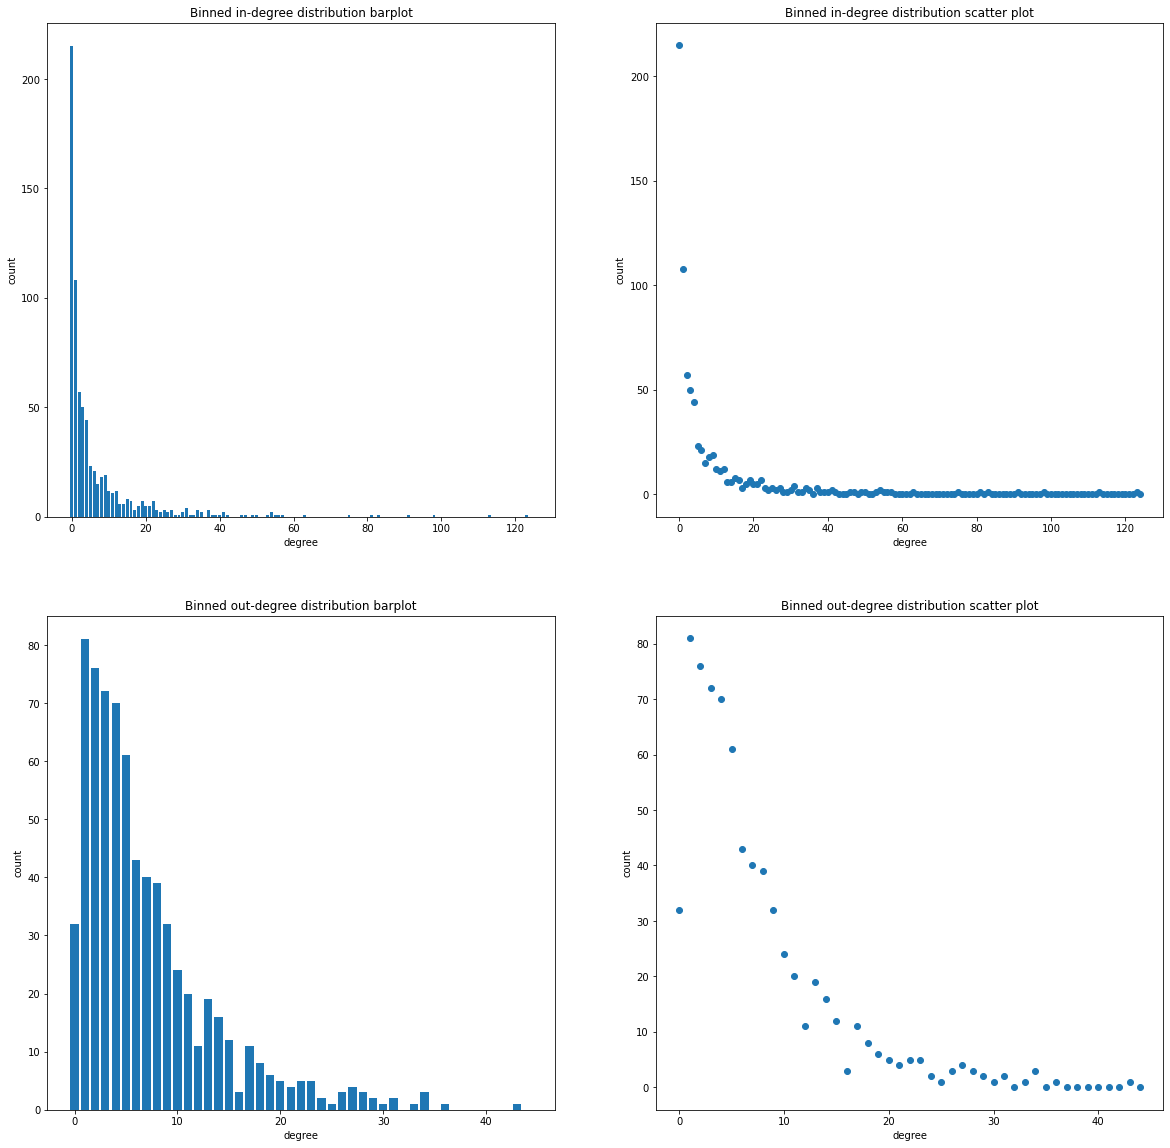

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax[0][0].bar(in_bins, in_bins_count, width=.8)

ax[0][0].set_title('Binned in-degree distribution barplot')
ax[0][0].set_xlabel("degree", fontsize=10)
ax[0][0].set_ylabel("count", fontsize=10)

# we use bar and scatter plots of the same distributions for better visualization purposes
ax[0][1].scatter(in_bins, in_bins_count)
ax[0][1].set_title('Binned in-degree distribution scatter plot')
ax[0][1].set_xlabel("degree", fontsize=10)
ax[0][1].set_ylabel("count", fontsize=10)

ax[1][0].bar(out_bins, out_bins_count, width=.8)
ax[1][0].set_title('Binned out-degree distribution barplot')
ax[1][0].set_xlabel("degree", fontsize=10)
ax[1][0].set_ylabel("count", fontsize=10)

ax[1][1].scatter(out_bins, out_bins_count)
ax[1][1].set_title('Binned out-degree distribution scatter plot')
ax[1][1].set_xlabel("degree", fontsize=10)
ax[1][1].set_ylabel("count", fontsize=10)

plt.show()

💬 Comment:

Many rappers in the network are rarely mentioned by their peers on Wikipedia, and this holds true for both incoming and outgoing references. However, there is a specific subset of influential rappers who receive frequent mentions. This pattern is tied to the length of their Wikipedia articles.

It's important to note that a rapper's Wikipedia page usually includes mentions of their influences and associates, even if these references are not reciprocated. The number of references a rapper has is also influenced by the length of their Wikipedia article, which is determined by their achievements and the interest of Wikipedia contributors.

This pattern arises from the network's structure, where connections are established between two rappers if there are hyperlinks on one rapper's page leading to the other's. Well-known rappers naturally have more connections from others, resulting in higher in-degrees. Conversely, less famous rappers may have links to other rappers but few connections leading to them, often resulting in low in-degrees. Out-degrees are also constrained by page length and the number of hyperlinks a rapper includes on their page.

- Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?

**✅ Solution**

In [27]:
in_exponent, out_exponent = powerlaw.Fit(in_degrees).alpha, powerlaw.Fit(out_degrees).alpha
print(f"The exponent of the in-degree distribution is {in_exponent:.5f}.")
print(f"The exponent of the out-degree distribution is {out_exponent:.5f}.")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
The exponent of the in-degree distribution is 3.16908.
The exponent of the out-degree distribution is 8.09868.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


**💬 Comment:**


Based on the preceding findings, it can be inferred that the exponent of the in-degree distribution is almost three times greater than that of the out-degree distribution. In our network, this indicates a tendency for nodes to possess a greater number of outgoing edges directed towards other nodes, compared to incoming edges originating from other nodes.

- Compare the two degree distributions to the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

**💬 Comment:**

To assess how the degree distribution of the undirected graph we generated earlier compares to that of a random network with the same node count and connection probability, we begin by generating a random graph. We do this by using the networkx function `gnm_random_graph`, ensuring it has the same number of nodes and edges as our initial undirected graph. Next, we employ our `get_degree_distribution` function to extract the degree distributions for both the undirected and random graphs.

**📊 Graph**

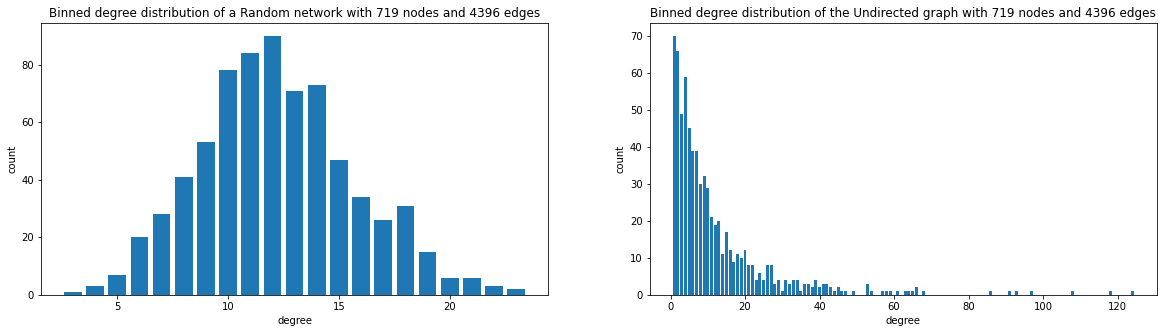

In [28]:
# Function to compute degree distribution
def get_degree_distribution(graph):
    degree_count = {}
    for degree in graph:
        degree_count[degree] = degree_count.get(degree, 0) + 1
    degrees, counts = zip(*sorted(degree_count.items()))
    return degrees, counts

# Compute the number of nodes and edges in the undirected graph
total_gu_nodes = len(G_undirected.nodes())
total_gu_links = len(G_undirected.edges())

# Generate a random graph with the same number of nodes and edges
random_G = nx.gnm_random_graph(n=total_gu_nodes, m=total_gu_links)

# Get degree distributions for both graphs
random_degrees, random_counts = get_degree_distribution(dict(random_G.degree()).values())
gu_degrees, gu_counts = get_degree_distribution(dict(G_undirected.degree()).values())

# Create subplots
fig, (ax_0, ax_1) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot degree distribution for random graph
ax_0.bar(random_degrees, random_counts, width=0.8)
ax_0.set_title(f'Binned degree distribution of a Random network with {total_gu_nodes} nodes and {total_gu_links} edges')
ax_0.set_xlabel("degree", fontsize=10)
ax_0.set_ylabel("count", fontsize=10)

# Plot degree distribution for undirected graph
ax_1.bar(gu_degrees, gu_counts)
ax_1.set_title(f'Binned degree distribution of the Undirected graph with {total_gu_nodes} nodes and {total_gu_links} edges')
ax_1.set_xlabel("degree", fontsize=10)
ax_1.set_ylabel("count", fontsize=10)

# Show the plots
plt.show()


**💬 Comment:**

Upon initial examination, it's evident that both degree distributions within the rapper network show a strong bias towards lower degrees, indicating a prevalence of nodes with minimal connections. Furthermore, in both distributions, there is a clear extension towards higher degrees, suggesting the existence of a limited number of nodes scattered thinly across a wide range of high degrees. These features are particularly prominent in the In-degree distribution and are in accordance with the exponent calculated in the previous section. This consistency underscores the network's scale-free nature, characterized by an abundance of nodes with low degrees and a scarcity of hubs, which are nodes with exceptionally high degrees.

In contrast, when we consider the degree distribution of the random network, it exhibits a similarity to a normal distribution. The higher degrees are centered around middle values, ranging from 11 to 14, with the mean value around 13, which represents the average degree in this random network. However, in the Undirected graph, there is a solitary high peak at degree 0, and the degree count gradually diminishes afterward, indicating a different distribution pattern compared to the rapper network.







## Exercise 1b: Visualization <a class="viz" id="viz"></a>
- Create a nice visualization of the total (directed) network:
   - Color nodes according to the role;
   - Scale node-size according to degree;
   - Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
   - Whatever else you feel like that would make the visualization nicer.

**📊 Graph**

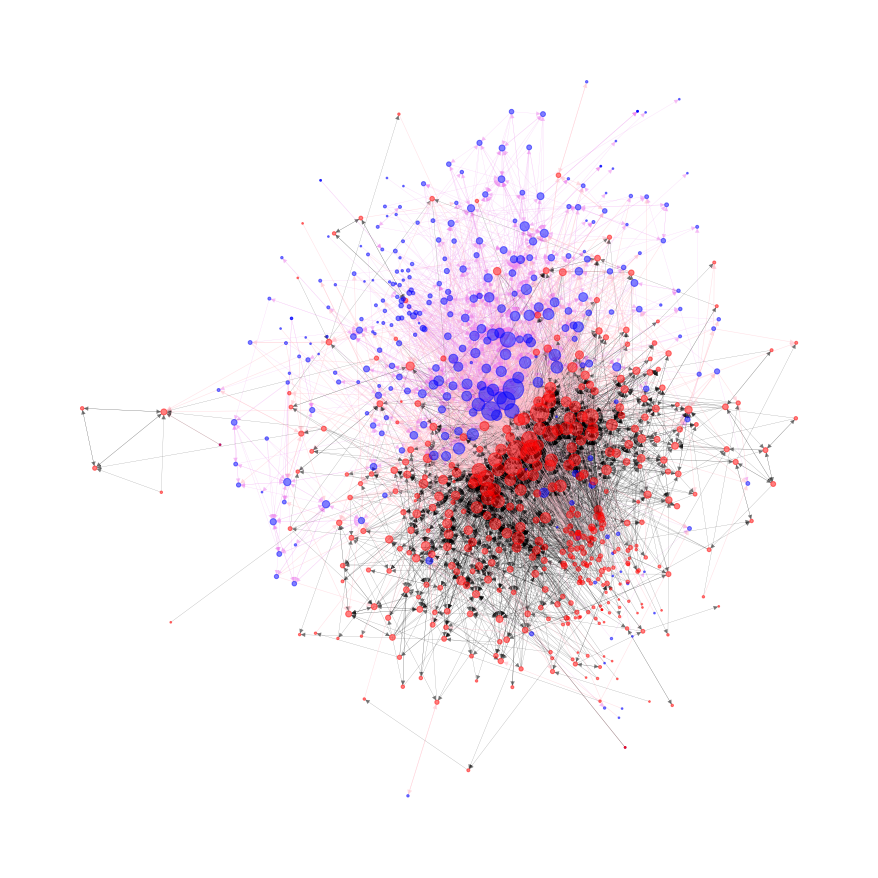

In [42]:
def get_node_color(node, attribute_dict, default="white"):
    location = node.get('Location', default)
    return attribute_dict.get(location, default)

def get_edge_attribute(u, v, nodes, attribute_dict, default=None):
    edge_key = f"{nodes[u]['Location']}-{nodes[v]['Location']}"
    return attribute_dict.get(edge_key, default)

def draw_graph(G):
    # Node properties
    node_colors = [get_node_color(G.nodes[n], node_colors_dict) for n in G.nodes()]

    # Edge properties
    edge_colors = [get_edge_attribute(u, v, G.nodes, edge_colors_dict) for u, v in G.edges()]
    edge_widths = [get_edge_attribute(u, v, G.nodes, edge_widths_dict, default=1.0) for u, v in G.edges()]

    # Drawing graph
    degree_dict = dict(G.degree)
    plt.figure(1, figsize=(12,12))
    nx.draw_kamada_kawai(
        G, 
        node_size=[v * 3 for v in degree_dict.values()], 
        node_color=node_colors, 
        edge_color=edge_colors, 
        width=edge_widths, 
        alpha=0.5
    )

node_colors_dict = {"West": "blue", "East": "red"}
edge_colors_dict = {
    "West-East": "pink", 
    "East-West": "pink", 
    "West-West": "violet", 
    "East-East": "black"
}
edge_widths_dict = {
    "West-East": 0.5, 
    "East-West": 0.5, 
    "West-West": 0.2, 
    "East-East": 0.2
}

draw_graph(G)


- Describe the structure you observe. What useful information can you decipher from this?

**💬 Comment:**


The graph distinctly showcases network clusters aligned with each coast, highlighting a clear bifurcation. Minor deviations exist, but they're marginal. The demarcation becomes less defined near central, larger nodes, supporting the increased inter-coastal rapper affiliations. While the network exhibits a few dominant nodes and many lesser ones, this disparity would be more accentuated if relying solely on in-degrees. Presently, the degree distribution aligns with a power-law distribution, nearing an exponent of 3, but doesn't fully embody scale-free attributes.






## 2. Word-clouds <a class="anchor" id="wordclouds"></a>

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
- Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.

- For each coast, what are the 5 words with the highest TR scores? Comment on your result.

## 3. Communities <a class="anchor" id="communities"></a>
Find communities and their modularity. Here's what you need to do:
- In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 

- Find communities in the network

- Explain how you chose to identify the communities: Which algorithm did you use and how does it work?

- Comment on your results:
    - How many communities did you find in total?

- Compute the value of modularity with the partition created by the algorithm.

- Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.


Now, partition your rappers into two communities based on which coast they represent.
  - What is the modularity of this partition? Comment on the result.

## 4. Sentiment of communities <a class="anchor" id="sentiment"></a>

Analyze the sentiment of communities.

Here's what you need to do (use the LabMIT wordlist approach):

- Calculate and store sentiment for every rapper

- Create a histogram of all rappers' associated sentiments.

- What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
- Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).

- Use the "label shuffling test" to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

- Does the result make sense to you? Elaborate.

A couple of additional instructions you will need below:
- Average the average sentiment of the nodes in each community to find a community-level sentiment.

## 5. References <a class="anchor" id="references"></a>

[1] Dodds, Peter Sheridan, et al. "Temporal patterns of happiness and information in a global social network: Hedonometrics and Twitter." PloS one 6.12 (2011): e26752. [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)

[2] Longhurst, J. W. S., D. Rayfield, and D. E. Conlan. 1994. "The Impacts Of Road Transport On Urban Air Quality-A Case Study Of The Greater Manchester Region." WIT Transactions on Ecology and the Environment 3.
